## Scrape Weather Data using Beautifulsoup and Selenium

This notebook performs a comprehensive analysis of weather data by loading and preprocessing the dataset, including renaming columns to English, converting dates, and handling missing values through interpolation. The data, which includes temperature, precipitation, sunshine hours, snow depth, and wind gusts, is cleaned by replacing invalid entries and converting numeric columns to the correct format. Summary statistics and visualizations like histograms and box plots are used to explore and validate the data, ensuring it's ready for further analysis or modeling.

In [3]:
import time
from datetime import datetime, timedelta
import os
from typing import List
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import sqlite3

### Web Scraper

In [4]:
def configure_webdriver() -> webdriver.Chrome:
    """Configures and returns a Chrome WebDriver instance."""
    return webdriver.Chrome()

def accept_cookies(driver: webdriver.Chrome) -> None:
    """Accepts the cookies on the webpage if the cookie banner is present."""
    try:
        iframe = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'iframe[id^="sp_message_iframe_"]'))
        )
        driver.switch_to.frame(iframe)

        accept_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[title="Zustimmen"]'))
        )
        accept_button.click()
        driver.switch_to.default_content()
        time.sleep(2)
    except TimeoutException:
        print("No cookie banner found or unable to click the accept button.")
    except Exception as e:
        print(f"An error occurred: {e}")

def set_date_and_duration(driver: webdriver.Chrome, end_date: datetime) -> None:
    """Updates the URL to set the date range and duration to 8 weeks."""
    start_date = end_date - timedelta(weeks=8)
    url = f"https://www.wetterkontor.de/de/wetter/deutschland/rueckblick.asp?id=203&datum0={start_date.strftime('%d.%m.%Y')}&datum1={end_date.strftime('%d.%m.%Y')}&jr={end_date.year}&mo={end_date.month}&datum={end_date.strftime('%d.%m.%Y')}&t=8&part=2"
    driver.get(url)
    time.sleep(5)

def scrape_table(driver: webdriver.Chrome) -> List[List[str]]:
    """Scrapes the weather data table from the webpage."""
    try:
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "extremwerte")))
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        table = soup.find('table', {'id': 'extremwerte'})
        rows = table.find('tbody').find_all('tr')

        data = []
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            data.append(cols)
        
        return data
    except Exception as e:
        print(f"An error occurred while scraping the table: {e}")
        return []

def main():
    """Main function to execute the web scraping process and save the data to a CSV file."""
    driver = configure_webdriver()
    driver.get("https://www.wetterkontor.de/de/wetter/deutschland/rueckblick.asp?id=203")

    accept_cookies(driver)

    end_date = datetime.now() - timedelta(days=1)
    start_date = datetime.strptime('2020-11-13', '%Y-%m-%d')

    all_data = []

    while end_date > start_date:
        set_date_and_duration(driver, end_date)
        data = scrape_table(driver)
        all_data.extend(data)
        end_date -= timedelta(weeks=8)

    driver.quit()

    # Convert the scraped data to a DataFrame
    columns = ['Datum', 'Minimum Temp [°C]', 'Maximum Temp [°C]', 'Mittel Temp [°C]', 'Niederschlag [l/m2]', 'Sonnenschein [h]', 'Max Windböe', 'Schneehöhe [cm]']
    df = pd.DataFrame(all_data, columns=columns)

    # Split 'Max Windböe' into 'Max Windböe [Bft]' and 'Max Windböe [km/h]'
    df[['Max Windböe [Bft]', 'Max Windböe [km/h]']] = df['Max Windböe'].str.extract(r'(\d)(\d+)')
    df['Max Windböe [Bft]'] = df['Max Windböe [Bft]'].astype(float)
    df['Max Windböe [km/h]'] = df['Max Windböe [km/h]'].astype(float)
    df.drop(columns=['Max Windböe'], inplace=True)

    # Save the data to a CSV file
    df.to_csv('../data/raw/weather_data.csv', index=False)
    print("Data has been saved to weather_data.csv")

if __name__ == "__main__":
    main()


Data has been saved to weather_data.csv


---

### Inspect and Clean Data

In [5]:
file_path = '../data/raw/weather_data.csv'
df = pd.read_csv(file_path)

In [6]:
df.head(10)

,Datum,Minimum Temp [°C],Maximum Temp [°C],Mittel Temp [°C],Niederschlag [l/m2],Sonnenschein [h],Schneehöhe [cm],Max Windböe [Bft],Max Windböe [km/h]
0,06.04.2024,"7,6",25,"16,1",0,"11,1",0,6.0,40.0
1,07.04.2024,"9,1",23,17,0,"6,6",0,4.0,26.0
2,08.04.2024,"8,9","27,1","18,1",0,"8,2",0,4.0,22.0
3,09.04.2024,"5,1","18,2","10,6","0,5","1,1",0,6.0,50.0
4,10.04.2024,"1,6","12,2","6,8",0,"3,7",0,4.0,21.0
5,11.04.2024,"-0,5","15,6",8,0,"11,1",0,4.0,28.0
6,12.04.2024,"1,3","20,6","11,3",0,"12,7",0,4.0,20.0
7,13.04.2024,"4,2","23,6","14,7",0,"12,1",0,4.0,26.0
8,14.04.2024,"8,3","24,9","16,2","0,4","10,9",0,6.0,40.0
9,15.04.2024,"2,2","16,2","11,7","2,6",3,0,7.0,62.0


In [5]:
# Drop 'Max Windböe [Bft]' column 
df.drop(columns=['Max Windböe [Bft]'], inplace=True)

In [6]:
# Rename all columns in English
df.columns = [
    'Date', 'Min Temp [°C]', 'Max Temp [°C]', 'Mean Temp [°C]', 'Precipitation [l/m2]', 
    'Sunshine [h]', 'Snow Depth [cm]', 'Max Wind Gust [km/h]'
]

In [7]:
# Replace commas with periods in relevant columns and convert to numeric
columns_to_convert = [
    'Min Temp [°C]', 'Max Temp [°C]', 'Mean Temp [°C]', 
    'Precipitation [l/m2]', 'Sunshine [h]', 'Snow Depth [cm]'
]

for column in columns_to_convert:
    df[column] = df[column].replace('-', np.nan)
    df[column] = df[column].str.replace(',', '.').astype(float)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1288 non-null   object 
 1   Min Temp [°C]         1288 non-null   float64
 2   Max Temp [°C]         1288 non-null   float64
 3   Mean Temp [°C]        1288 non-null   float64
 4   Precipitation [l/m2]  1288 non-null   float64
 5   Sunshine [h]          1288 non-null   float64
 6   Snow Depth [cm]       1159 non-null   float64
 7   Max Wind Gust [km/h]  1288 non-null   float64
dtypes: float64(7), object(1)
memory usage: 80.6+ KB


In [9]:
# Verify min and max 'Date' range
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
min_date = df['Date'].min()
max_date = df['Date'].max()
print(f"Date range: {min_date} to {max_date}")

Date range: 2020-10-07 00:00:00 to 2024-04-16 00:00:00


In [10]:
# Calculate the number of missing days
date_range = pd.date_range(start=min_date, end=max_date)
missing_days = date_range.difference(df['Date'])
print(f"Number of missing days: {len(missing_days)}")

Number of missing days: 0


In [11]:
# Calculate the number of missing values per column
missing_values = df.isnull().sum()
print("Number of missing values per column:")
print(missing_values)

Number of missing values per column:
Date                      0
Min Temp [°C]             0
Max Temp [°C]             0
Mean Temp [°C]            0
Precipitation [l/m2]      0
Sunshine [h]              0
Snow Depth [cm]         129
Max Wind Gust [km/h]      0
dtype: int64


In [12]:
# Check if values are reasonable
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1288,2022-07-12 12:00:00,2020-10-07 00:00:00,2021-08-24 18:00:00,2022-07-12 12:00:00,2023-05-30 06:00:00,2024-04-16 00:00:00,NaN
Min Temp [°C],1288.0,3.611025,-14.4,-1.1,3.3,8.4,18.2,6.115068
Max Temp [°C],1288.0,13.184938,-7.6,6.475,12.45,20.5,35.4,8.759658
Mean Temp [°C],1288.0,8.426165,-10.6,3.1,7.8,14.7,25.3,7.167841
Precipitation [l/m2],1288.0,1.947981,0.0,0.0,0.0,2.0,56.4,4.56625
Sunshine [h],1288.0,5.036335,0.0,0.6,3.9,8.725,15.7,4.588024
Snow Depth [cm],1159.0,0.712683,0.0,0.0,0.0,0.0,31.0,2.893224
Max Wind Gust [km/h],1288.0,32.83618,7.0,24.0,31.0,40.0,86.0,12.465662


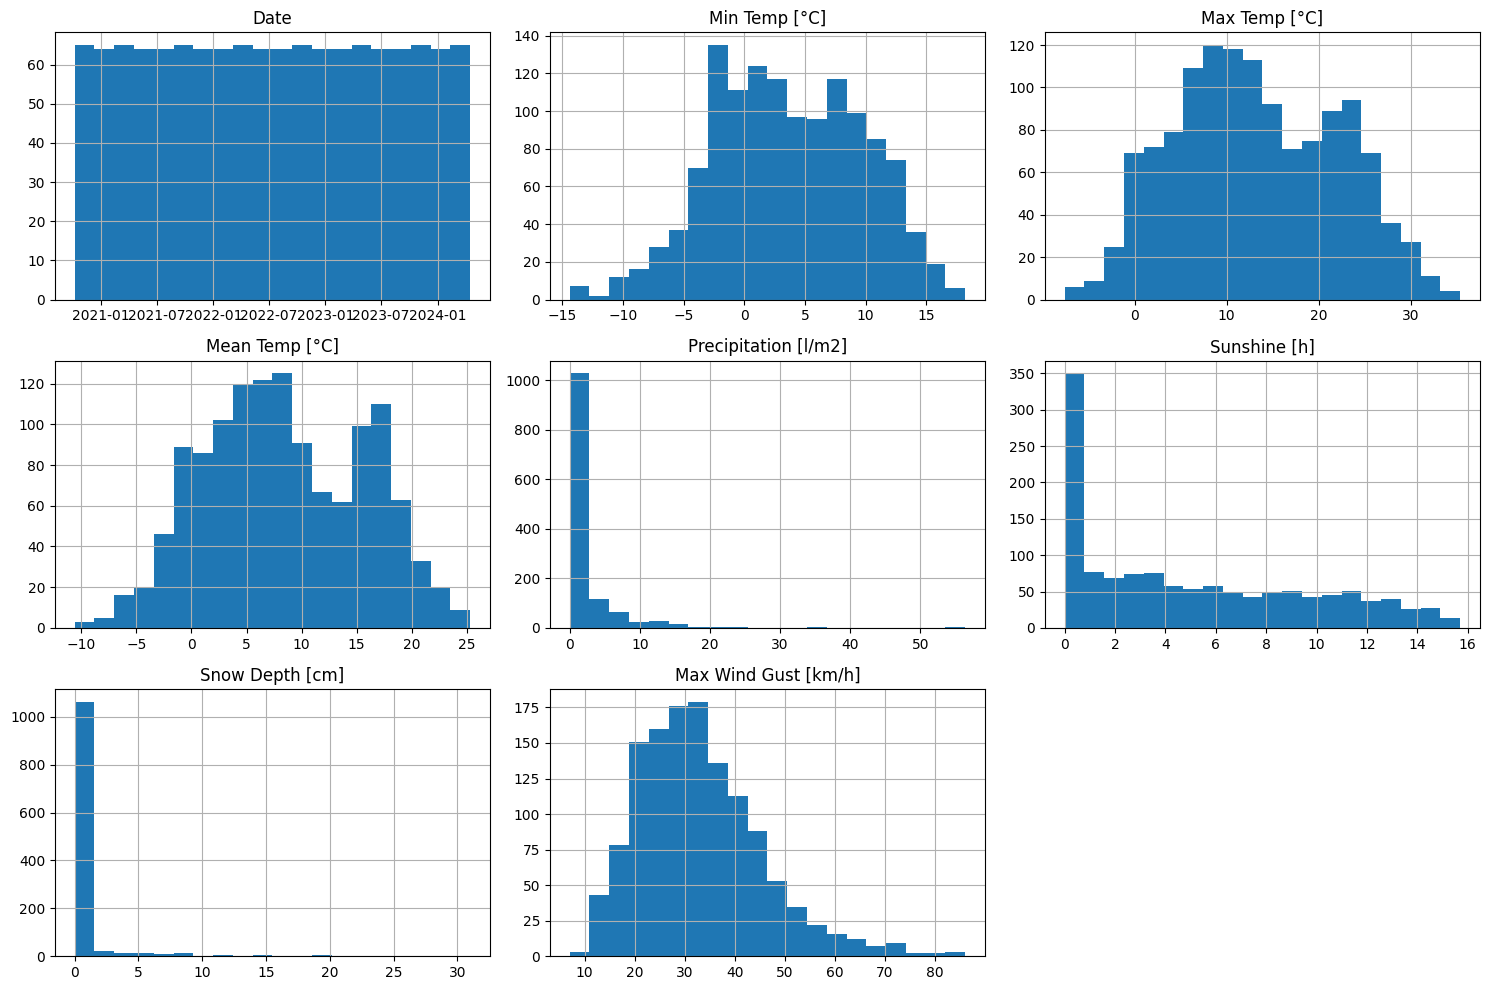

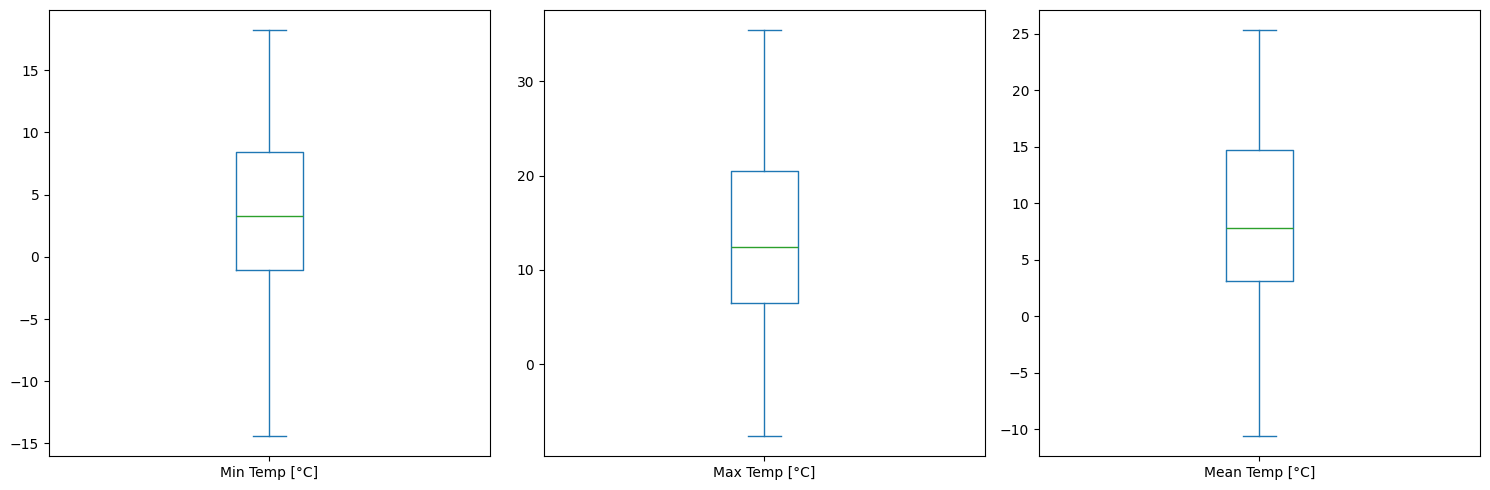

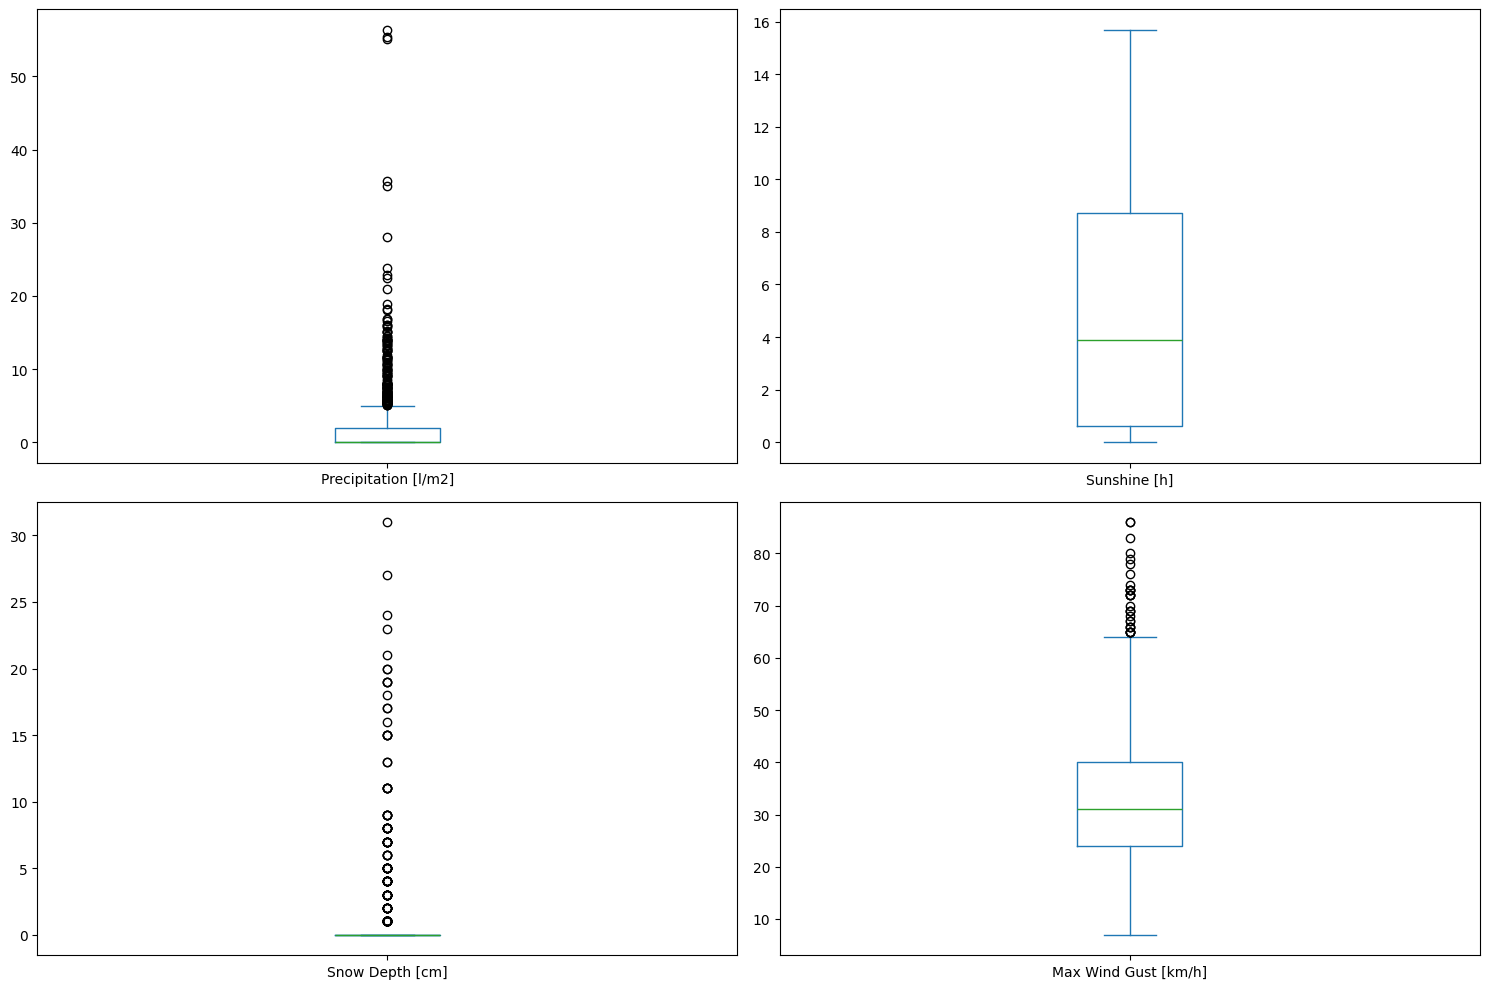

In [13]:
# Plot histograms for each column
df.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Distribution plots for specific columns
df[['Min Temp [°C]', 'Max Temp [°C]', 'Mean Temp [°C]']].plot(kind='box', subplots=True, layout=(1, 3), figsize=(15, 5))
plt.tight_layout()
plt.show()

df[['Precipitation [l/m2]', 'Sunshine [h]', 'Snow Depth [cm]', 'Max Wind Gust [km/h]']].plot(kind='box', subplots=True, layout=(2, 2), figsize=(15, 10))
plt.tight_layout()
plt.show()

In [14]:
# Interpolate missing values
df['Snow Depth [cm]'] = df['Snow Depth [cm]'].interpolate(method='linear')

---

### Write Cleaned Data to csv

In [16]:
# Define the file path
csv_file = os.path.join('..', 'data', 'transformed', 'weather_data_cleaned.csv')
os.makedirs(os.path.dirname(csv_file), exist_ok=True)

# Save the dataframe as a CSV file
df.to_csv(csv_file, index=False)
print(f'Data saved to {csv_file}')

Data saved to ..\data\processed\weather_data_cleaned.csv
